## Thêm thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


## Tiền xử lý

### read data

In [2]:
# Load the data
df = pd.read_csv('PFE-Pfizer.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,41.375713,41.546490,41.072105,41.138519,33.265743,26667781
1,2019-03-04,41.214420,41.356735,40.683113,40.863377,33.043259,22805820
2,2019-03-05,40.882355,41.034157,40.654648,40.692600,32.905163,26529812
3,2019-03-06,40.626186,40.673622,39.487667,39.715370,32.114948,22410359
4,2019-03-07,39.715370,39.743832,39.136623,39.269451,31.754372,29046132
...,...,...,...,...,...,...,...
1318,2024-05-24,28.670000,28.990000,28.549999,28.879999,28.879999,22576300
1319,2024-05-28,28.799999,28.879999,28.129999,28.299999,28.299999,32371200
1320,2024-05-29,28.160000,28.170000,27.690001,27.820000,27.820000,24241700
1321,2024-05-30,27.910000,28.200001,27.790001,28.200001,28.200001,23330700


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Create new dataframe with Date and Close
df_close = pd.DataFrame(df, columns=['Close'])

### Data normalization

In [4]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))

### Data splitting

In [5]:
# Split the data into training and test sets
train_size = int(len(df_close) * 0.8)
test_size = len(df_close) - train_size

train_data = df_close[:train_size]
test_data = df_close[train_size:]

In [6]:
# Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
	
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model training and testing

In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Using early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=earlystop)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0751
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0126
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0056
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0042
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0039
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0035
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0035
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0035
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0036
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0034
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0027
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0030
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0030
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0032
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/ste

### Testing process

In [9]:
# Predict
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step


### Evaluate model

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  467273701971.3606
RMSE on Test dataset:  0.02240400366544664
MSLE on Test dataset:  0.0003688267221153391
MAE on Test dataset:  0.01795644463879543


## Predicting the next 60 days

### Preparing the prediction data

In [11]:
# Predict the next 60 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
prediction_next60_days = []

for i in range(60):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        prediction_next60_days.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next60_days.extend(y_hat.tolist())

# Print predictions for the next 60 days
print(prediction_next60_days)

[[0.0952826738357544], [0.0948808416724205], [0.09547324478626251], [0.09666019678115845], [0.09821031987667084], [0.09998787939548492], [0.10191124677658081], [0.10392943024635315], [0.10600915551185608], [0.10812756419181824], [0.110268235206604], [0.11241893470287323], [0.11457039415836334], [0.11671550571918488], [0.11884891986846924], [0.12096654623746872], [0.12306542694568634], [0.12514357268810272], [0.12719954550266266], [0.12923264503479004], [0.13124245405197144], [0.13322895765304565], [0.135192409157753], [0.13713310658931732], [0.1390516310930252], [0.14094844460487366], [0.1428241729736328], [0.14467939734458923], [0.1465146839618683], [0.14833056926727295], [0.1501275897026062], [0.15190617740154266], [0.15366679430007935], [0.15540984272956848], [0.15713566541671753], [0.15884456038475037], [0.16053690016269684], [0.16221290826797485], [0.16387280821800232], [0.16551688313484192], [0.16714531183242798], [0.16875827312469482], [0.17035600543022156], [0.17193862795829773

### Preparing the forecast date index

In [12]:
# Print predictions for the next 60 days
print(prediction_next60_days)

# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 60 days
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60, freq='D')

# Convert predictions back to original scale
prediction_next60_days = scaler.inverse_transform(prediction_next60_days).reshape(-1)
y_pred = scaler.inverse_transform(y_pred)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

[[0.0952826738357544], [0.0948808416724205], [0.09547324478626251], [0.09666019678115845], [0.09821031987667084], [0.09998787939548492], [0.10191124677658081], [0.10392943024635315], [0.10600915551185608], [0.10812756419181824], [0.110268235206604], [0.11241893470287323], [0.11457039415836334], [0.11671550571918488], [0.11884891986846924], [0.12096654623746872], [0.12306542694568634], [0.12514357268810272], [0.12719954550266266], [0.12923264503479004], [0.13124245405197144], [0.13322895765304565], [0.135192409157753], [0.13713310658931732], [0.1390516310930252], [0.14094844460487366], [0.1428241729736328], [0.14467939734458923], [0.1465146839618683], [0.14833056926727295], [0.1501275897026062], [0.15190617740154266], [0.15366679430007935], [0.15540984272956848], [0.15713566541671753], [0.15884456038475037], [0.16053690016269684], [0.16221290826797485], [0.16387280821800232], [0.16551688313484192], [0.16714531183242798], [0.16875827312469482], [0.17035600543022156], [0.17193862795829773

## Visualization

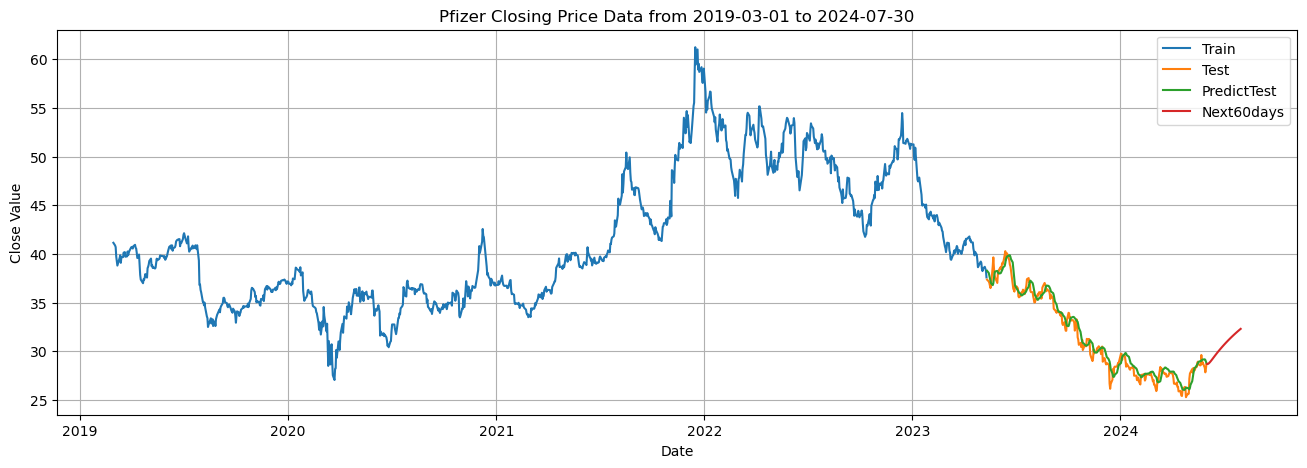

In [13]:
# Plotting
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], train_data, label='Train')
plt.plot(df.index[train_size:], test_data, label='Test')
plt.plot(df.index[train_size:], y_pred, label='PredictTest')
plt.plot(future_dates, prediction_next60_days, label='Next60days')

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title(f"Pfizer Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
plt.legend()
plt.grid()
plt.savefig('Image/LSTM_82_60days_PFE.png')
plt.show()